# Near to far field transformation

This tutorial will show you how to solve for electromagnetic fields far away from your structure using field information stored on a nearby surface.

This technique is called a 'near field to far field transformation' and is very useful for reducing the simulation size needed for structures involving lots of empty space.

As an example, we will simulate a simple zone plate lens with a very thin domain size to get the transmitted fields measured just above the structure.  Then, we'll show how to use the `Near2Far` feature from `Tidy3D` to extrapolate to the fields at the focal plane above the lens.

To verify correctness, the results will be compared to the case where the fields are directly monitored at the focal plane above the lens.

In [82]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Problem Setup
Below is a rough sketch of the setup of a near field to far field transformation.

The transmitted near fields are measured just above the metalens on the blue line, and the near field to far field transformation is then used to project the fields to the focal plane above at the red line.

In order to validate the results, a second reference simulation will be created with a larger simulation domain along the z axis, so that we can place a field monitor at the focal plane to compare with the results from the far field transformation.

<img src="img/n2f_diagram.png" width=800>

## Define Simulation Parameters

As always, we first need to define our simulation parameters.  As a reminder, all length units in `tidy3D` are specified in microns.

In [83]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1.0

# numerical aperture
NA = 0.8

# height of lens features
height_lens = 200 * nm

# space between bottom PML and substrate (-z)
# and the space between lens structure and top pml (+z)
space_below_sub = 1.5 * wavelength

# height of substrate (um)
height_sub = wavelength / 2

# side length (xy plane) of entire metalens (um)
length_xy = 20 * wavelength

# Lens and substrate refractive index
n_TiO2 = 2.40
n_SiO2 = 1.46

# define material properties
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

## Process Geometry

Next we perform some conversions based on these parameters to define the simulation.

In [84]:
# grid size (um)
dl = .05

# because the wavelength is in microns, use builtin td.C_0 (um/s) to get frequency in Hz
f0 = td.C_0 / wavelength

# Define PML layers, for this application we surround the whole structure in PML to isolate the fields
pml_layers = 3*[td.PML()]

# domain size in z, note, we're just simulating a thin slice: (space -> substrate -> lens height -> space)
length_z = space_below_sub + height_sub + height_lens + space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Geometry

Now we create the ring metalens programatically

In [85]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + height_sub / 2.0],
        size=[td.inf, td.inf, height_sub]
    ),
    medium=SiO2
)

# focal length
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# far field measurement plane position along z
far_plane_z = focal_length + 0.0*wavelength

# far field measurement plane size along x and y
far_plane_xy = 4 * wavelength

# location from center for edge of the n-th inner ring, see https://en.wikipedia.org/wiki/Zone_plate
def edge(n):
    return np.sqrt(n * wavelength * focal_length + n**2 * wavelength**2 / 4)

# loop through the ring indeces until it's too big and add each to geometry list
n = 1
r = edge(n)
rings = []
while r < 2 * length_xy:
    # progressively wider cylinders, material alternating between air and TiO2 

    cylinder = td.Structure(
        geometry=td.Cylinder(
            center=[0,0,-length_z/2  + space_below_sub + height_sub + height_lens / 2],
            axis=2,
            radius=r,
            length=height_lens),
        medium=TiO2 if n % 2 == 0 else air,
    )
    rings.append(cylinder)
    
    n += 1
    r = edge(n)

# reverse geometry list so that inner, smaller rings are added last and therefore override larger rings.
rings.reverse()

# create the PEC plane with aperture
width = 1 * wavelength

pec_center_z = -length_z/2 + space_below_sub + height_sub + height_lens + space_below_sub / 4.0

# pec_center_offset = td.inf/2
pec_center_offset = length_xy/4+width+wavelength/2

# pec_length_xy = td.inf-width
pec_length_xy = length_xy/2+width/4+wavelength

left = td.Structure(
    geometry=td.Box(
        center=[-pec_center_offset, 0, pec_center_z],
        size=[pec_length_xy, td.inf, height_sub/2.0]),
    medium=td.PEC)
right = td.Structure(
    geometry=td.Box(
        center=[pec_center_offset, 0, pec_center_z],
        size=[pec_length_xy, td.inf, height_sub/2.0]),
    medium=td.PEC)
top = td.Structure(
    geometry=td.Box(
        center=[0, -pec_center_offset, pec_center_z],
        size=[td.inf, pec_length_xy, height_sub/2.0]),
    medium=td.PEC)
bottom = td.Structure(
    geometry=td.Box(
        center=[0, pec_center_offset, pec_center_z],
        size=[td.inf, pec_length_xy, height_sub/2.0]),
    medium=td.PEC)

# geometry = [substrate] + rings
geometry = [substrate, left, right, top, bottom] + rings
# geometry = [left, right, top, bottom]

## Create Source

Create a plane wave incident from below the metalens

In [86]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

source = td.PlaneWave(
            center=(0,0,-length_z/2 + space_below_sub / 2),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='+',
            pol_angle=0)
            #polarization='Ex')

# source = td.VolumeSource(
#    center=(0,0,-length_z/2 + space_below_sub / 2),
#    size=(0.4 * wavelength, 0.4 * wavelength, 0),
#    source_time = gaussian,
#    polarization='Ex')

# Simulation run time
run_time = 40 / fwidth

## Create Monitors

Create a near field monitor to measure the fields just above the metalens. For verification later on, also create a far field monitor.

In [101]:
# place the near field monitor halfway between top of lens and PML
near_plane_z = -length_z/2 + space_below_sub + height_sub + height_lens + space_below_sub / 2
monitor_near = td.FieldMonitor(
    center=[0., 0., near_plane_z],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='nearfield'
)

# to measure reference results, place the far field monitor at the far plane
monitor_far = td.FieldMonitor(
    center=[0., 0., far_plane_z],
    size=[far_plane_xy, far_plane_xy, 0],
    freqs=[f0],
    name='farfield'
)

## Create Simulation

Put everything together and define a simulation object


In [88]:
simulation = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    monitors=[monitor_near],
    run_time=run_time,
    pml_layers=pml_layers
)

# Create a reference simulation object for directly measuring the fields on the focal plane
# This simulation domain must be large enough in the +z direction to include the focal plane,
# because monitors can be placed only within the simulation domain
z_extension = far_plane_z * 1.05
sim_size_ref = (length_xy, length_xy, length_z + z_extension)
simulation_ref = td.Simulation(
    size=sim_size_ref,
    center=(0, 0, z_extension/2.0),
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    monitors=[monitor_near, monitor_far],
    run_time=run_time,
    pml_layers=pml_layers
)

[00:20:01] WARNING  structure                                               ]8;id=863510;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=682308;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=158335;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=861589;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=455602;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=968590;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=964652;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=623527;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

/Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py:348: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_min = C_0 / f_average / n_material


           WARNING  structure                                               ]8;id=994747;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=246307;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=714151;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=161286;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=531096;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=969944;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=786238;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=95498;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

## Visualize Geometry

Lets take a look and make sure everything is defined properly


<Figure size 1440x576 with 6 Axes>

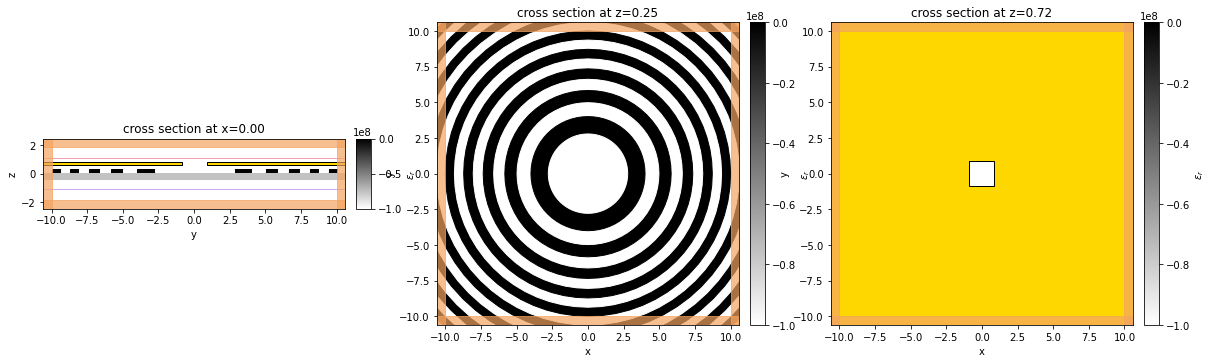

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
simulation.plot_eps(x=0, ax=ax1);
simulation.plot_eps(z=-length_z/2  + space_below_sub + height_sub + height_lens / 2, ax=ax2);
simulation.plot_eps(z=pec_center_z, ax=ax3);

<Figure size 1440x576 with 6 Axes>

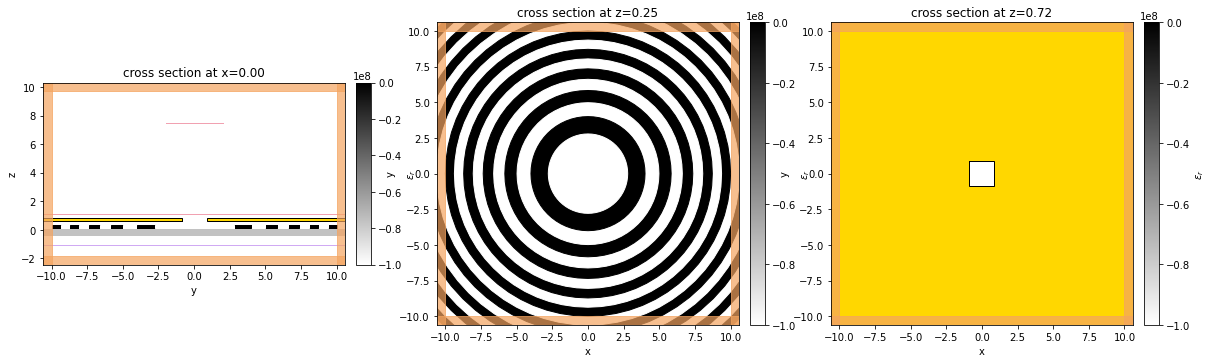

In [90]:
# also visualize the extended reference geometry
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
simulation_ref.plot_eps(x=0, ax=ax1);
simulation_ref.plot_eps(z=-length_z/2  + space_below_sub + height_sub + height_lens / 2, ax=ax2);
simulation_ref.plot_eps(z=pec_center_z, ax=ax3);

## Run Simulation

Now we can run the simulation and download the results


In [91]:
import tidy3d.web as web
sim_data = web.run(simulation, task_name='near2far', path='data/simulation.hdf5')
# sim_data = web.load('96a64427-03dd-4ee6-bec5-3805e6ad4954', simulation, path='data/simulation.hdf5')

# sim_data = td.SimulationData.from_file(f'data/simulation.hdf5')

[00:20:09] INFO     Uploaded task 'near2far' with task_id                       ]8;id=578001;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=258100;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#109\109]8;;\
                    'a204890b-258d-4d5a-9a96-3a1106f64aa8'.                                  

Output()

[00:20:10] status = queued                                                      ]8;id=783851;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=683322;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:21:29] status = preprocess                                                  ]8;id=634675;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=848835;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:23:01] status = running                                                     ]8;id=773536;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=57734;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:25:20] status = postprocess                                                 ]8;id=671283;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=901562;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:25:40] status = visualize                                                   ]8;id=503912;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=455270;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:25:51] status = success                                                     ]8;id=122341;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=850653;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:25:56] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=873294;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=950140;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#476\476]8;;\
                    "data/simulation.hdf5"                                                   

Output()

[00:26:48] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=762556;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=672556;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           WARNING  structure                                               ]8;id=887462;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=485790;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=747884;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=869557;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=966800;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=212956;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=163783;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=784135;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

Next, run the reference simulation with the extended domain

In [92]:
sim_data_ref = web.run(simulation_ref, task_name='near2far_ref', path='data/simulation_ref.hdf5')
# sim_data = web.load('96a64427-03dd-4ee6-bec5-3805e6ad4954', simulation, path='data/simulation.hdf5')


[00:26:55] INFO     Uploaded task 'near2far_ref' with task_id                   ]8;id=599344;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=140494;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#109\109]8;;\
                    '9703923f-cc59-4d8a-bc41-2f0889512ff0'.                                  

Output()

[00:26:57] status = queued                                                      ]8;id=107596;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520836;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:27:18] status = preprocess                                                  ]8;id=877369;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=820051;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:27:47] status = running                                                     ]8;id=138233;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=828045;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:32:14] status = postprocess                                                 ]8;id=169508;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=675860;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:32:31] status = visualize                                                   ]8;id=446725;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=636453;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:32:45] status = success                                                     ]8;id=809562;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=531407;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[00:32:45] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=768576;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990595;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#476\476]8;;\
                    "data/simulation_ref.hdf5"                                               

Output()

[00:32:57] INFO     loading SimulationData from data/simulation_ref.hdf5        ]8;id=988271;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771394;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           WARNING  structure                                               ]8;id=610445;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=195299;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=676299;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=140030;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=445771;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=395496;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=270523;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=268094;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Cylinder(center=(0.0, 0.0,                                      
                    0.24999999999999992), type='Cylinder', axis=2,                           
                    length=0.2, radius=10.0) medium=Medium(name=None,                        
                    frequency_range=None, type='Medium', permittivity=5.76,                  
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

## Visualization 

Let's inspect the near field using the Tidy3D builtin field visualization methods.

<Figure size 1080x252 with 6 Axes>

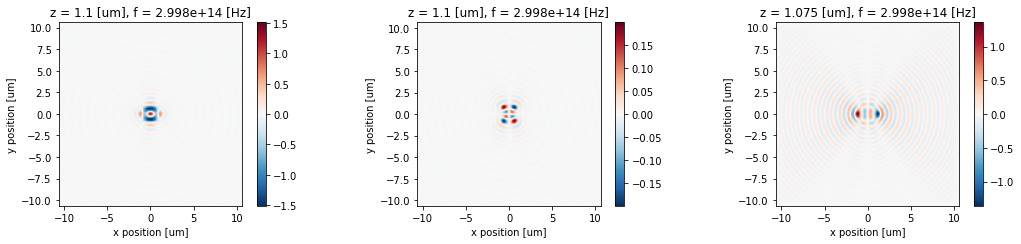

In [93]:
near_field_data = sim_data['nearfield']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='nearfield', field_name='Ex', z=near_plane_z, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ey', z=near_plane_z, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ez', z=near_plane_z, val='real', freq=f0, ax=ax3)

plt.show()

We can also inspect the far field data measured at the far field monitor.

<Figure size 1080x252 with 6 Axes>

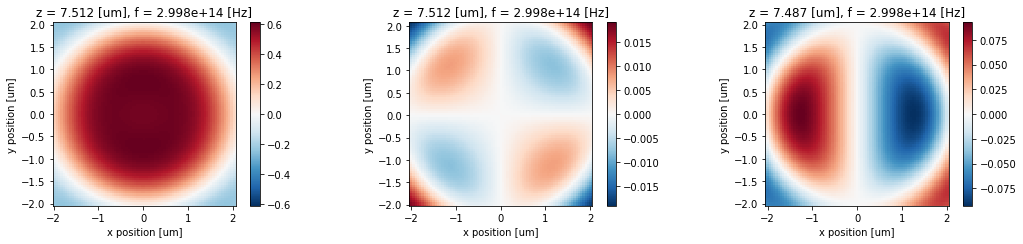

In [94]:
far_field_data = sim_data_ref['farfield']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ex', z=far_plane_z, val='real', freq=f0, ax=ax1)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ey', z=far_plane_z, val='real', freq=f0, ax=ax2)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ez', z=far_plane_z, val='real', freq=f0, ax=ax3)

plt.show()

## Setting Up Near 2 Far

To set up near to far, we first need to grab the data from the nearfield monitor. For testing purposes, we'll do this for both the original and the reference simulations.

Then, we create a `td.Near2Far` object using the monitor data dictionary as follows.

This object just stores near field data and provides [various methods](https://simulation.cloud/docs/html/generated/tidy3d.Near2Far.html#tidy3d.Near2Far) for looking at various far field quantities.

In [95]:
from tidy3d.plugins import Near2Far
n2f = Near2Far(sim_data, mon_name='nearfield', frequency=f0)
n2f_ref = Near2Far(sim_data_ref, mon_name='nearfield', frequency=f0)

## Getting Far Field Data

With the `Near2Far` object initialized, we just need to call one of it's methods to get a far field quantity.

For this example, we use `Near2Far.fields_cartesian(x,y,z)` to get the fields at an `x,y,z` point relative to the monitor center.

Below, we scan through x and y points in a plane located at `z=z0` and record the far fields.

At the same time, we'll also compute the far fields for the reference case.

In [96]:
# points to project to
num_far = 40
xs_far = far_plane_xy * np.linspace(-0.5, 0.5, num_far)
ys_far = far_plane_xy * np.linspace(-0.5, 0.5, num_far)

# initialize the far field values
E_far = np.zeros((3, num_far, num_far), dtype=complex)
H_far = np.zeros((3, num_far, num_far), dtype=complex)        

E_far_ref = np.zeros((3, num_far, num_far), dtype=complex)
H_far_ref = np.zeros((3, num_far, num_far), dtype=complex)        

from rich.progress import track

# loop through points in the output plane
for i in track(range(num_far), description='Performing Far-field transformation...'):

    x = xs_far[i]
    for j in range(num_far):
        y = ys_far[j]

        # compute and store the outputs from projection function at the focal plane
        E, H = n2f.fields_cartesian(x, y, far_plane_z-near_plane_z)
        E_far[:, i, j] = np.squeeze(E)
        H_far[:, i, j] = np.squeeze(H)
        
        # do the same for the reference simulation
        E_ref, H_ref = n2f_ref.fields_cartesian(x, y, far_plane_z-near_plane_z)
        E_far_ref[:, i, j] = np.squeeze(E_ref)
        H_far_ref[:, i, j] = np.squeeze(H_ref)

Output()

## Plot Results
Now we can plot the near and far fields together, as well as the directly-measured far field obtained from the reference simulation

<Figure size 936x648 with 18 Axes>

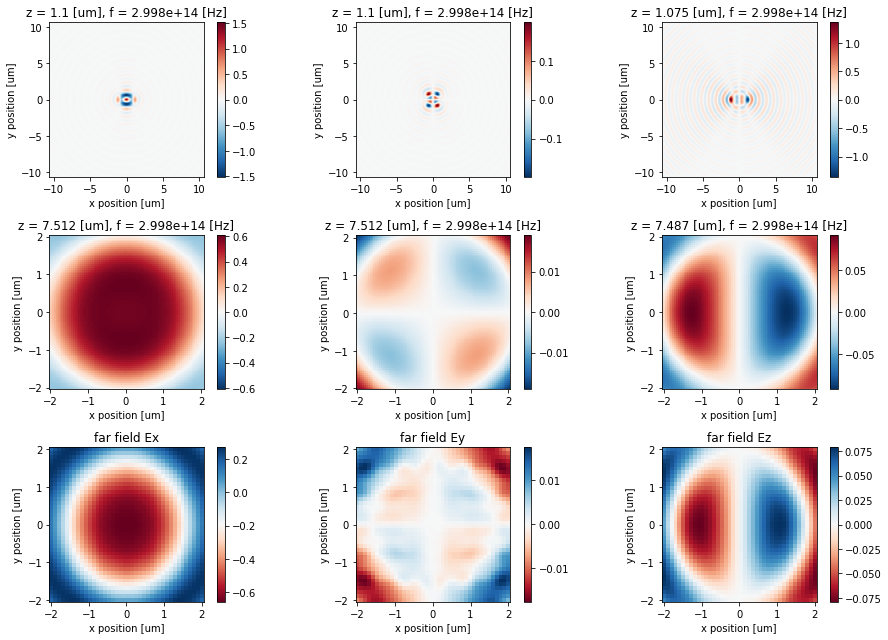

In [97]:
# plot everything
# fig, (axes_near, axes_near_ref, axes_far_ref, axes_near2far, axes_near2far_ref) =  plt.subplots(5, 3)
# fig.set_size_inches(13, 15)
fig, (axes_near, axes_far_ref, axes_near2far) =  plt.subplots(3, 3)
fig.set_size_inches(13, 9)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

testpos = (1.8, 1.2)

# Near field in the original simulation
ax1, ax2, ax3 = axes_near
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ex', z=near_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ey', z=near_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ez', z=near_plane_z, val=func, freq=f0, ax=ax3)

# Far field at the monitor in the reference simulation
ax1, ax2, ax3 = axes_far_ref
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ex', z=far_plane_z, val=func, freq=f0, ax=ax1)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ey', z=far_plane_z, val=func, freq=f0, ax=ax2)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ez', z=far_plane_z, val=func, freq=f0, ax=ax3)

# Far field via near2far in the original simulation
for ax, direction, E in zip(axes_near2far, 'xyz', E_far):
    im = pmesh(xs_far, ys_far, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()

<Figure size 936x648 with 18 Axes>

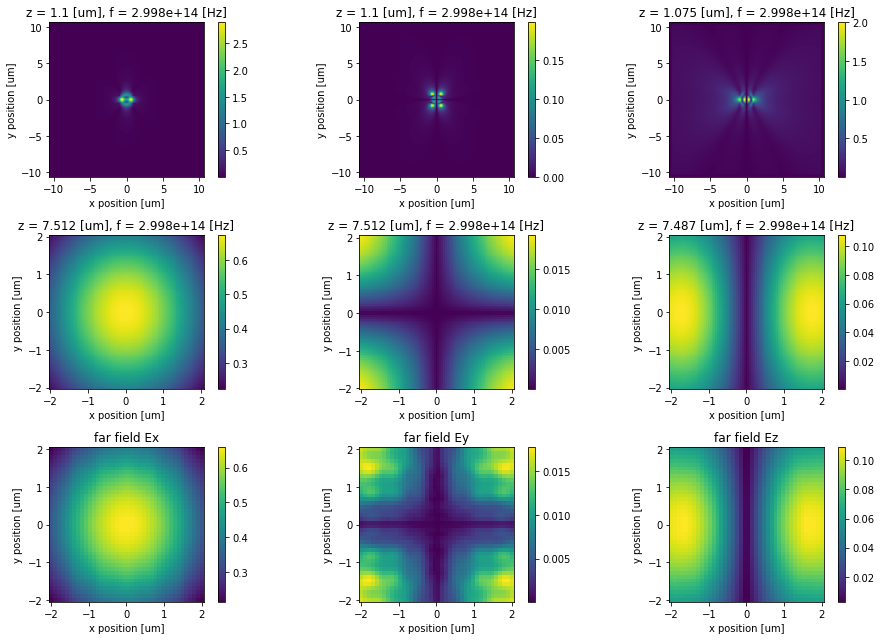

In [100]:
# plot everything
# fig, (axes_near, axes_near_ref, axes_far_ref, axes_near2far, axes_near2far_ref) =  plt.subplots(5, 3)
# fig.set_size_inches(13, 15)
fig, (axes_near, axes_far_ref, axes_near2far) =  plt.subplots(3, 3)
fig.set_size_inches(13, 9)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'abs'
def plotfunc(val):
    return np.abs(val)

testpos = (1.8, 1.2)

# Near field in the original simulation
ax1, ax2, ax3 = axes_near
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ex', z=near_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ey', z=near_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='nearfield', field_name='Ez', z=near_plane_z, val=func, freq=f0, ax=ax3)

# Far field at the monitor in the reference simulation
ax1, ax2, ax3 = axes_far_ref
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ex', z=far_plane_z, val=func, freq=f0, ax=ax1)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ey', z=far_plane_z, val=func, freq=f0, ax=ax2)
sim_data_ref.plot_field(field_monitor_name='farfield', field_name='Ez', z=far_plane_z, val=func, freq=f0, ax=ax3)

# Far field via near2far in the original simulation
for ax, direction, E in zip(axes_near2far, 'xyz', E_far):
    im = pmesh(xs_far, ys_far, plotfunc(E), ax=ax, cmap='viridis')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()

We can also use the far field data and plot the field intensity to see the focusing effect.

<Figure size 1080x360 with 4 Axes>

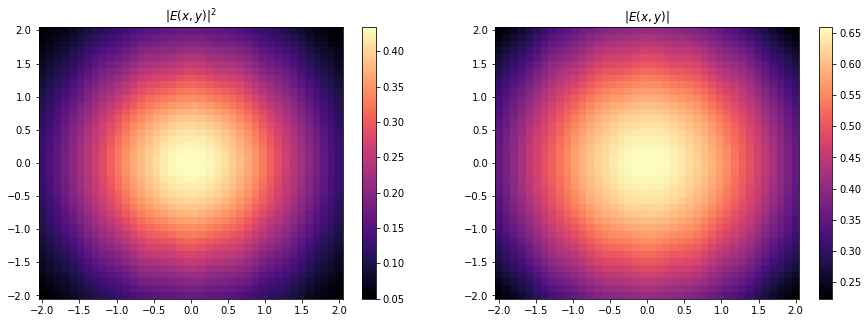

In [98]:
intensity_far = np.sum(np.square(np.abs(E_far)), axis=0)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

im1 = pmesh(xs_far, ys_far, intensity_far, ax=ax1, cmap='magma')
im2 = pmesh(xs_far, ys_far, np.sqrt(intensity_far), ax=ax2, cmap='magma')

ax1.set_title('$|E(x,y)|^2$')
ax2.set_title('$|E(x,y)|$')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.show()